Clustering model

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
df = pd.read_csv("SpotifyFeatures.csv")

feature_cols = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo"
]

X = df[feature_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA(n_components=0.9)
X_pca_full = pca_full.fit_transform(X_scaled)

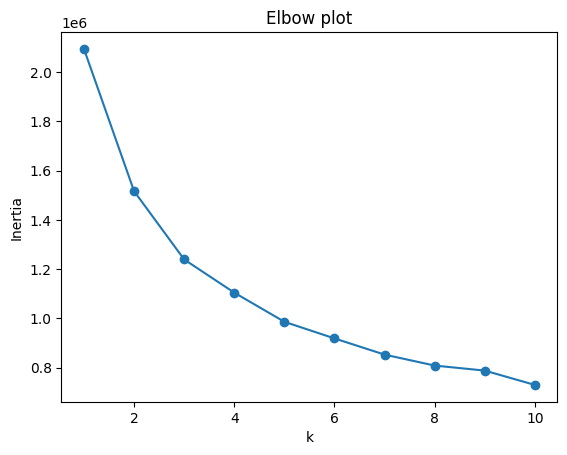

In [42]:
inertia = []
k_values = range(1, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(k_values, inertia, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow plot")
plt.show()

In [43]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
df["cluster"] = kmeans.fit_predict(X_pca_full)
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,cluster
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814,2
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816,2
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368,1
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227,1
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390,1


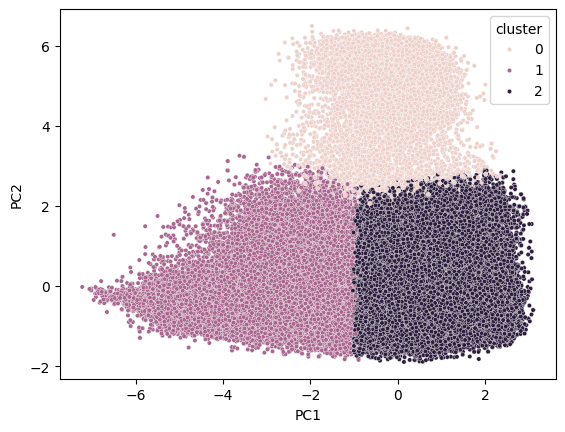

In [44]:
sns.scatterplot(data=df, x=X_pca_full[:,0], y=X_pca_full[:,1], hue="cluster", s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Ranking model

In [32]:
def find_features(df):
    features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
    X = df[features]
    y = LabelEncoder().fit_transform(df['genre'])

    rf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
    rf.fit(X, y)

    # Get importance scores
    importance = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nFeature Importance:")
    print(importance)

    return importance

In [33]:
importance = find_features(df)


Feature Importance:
            feature  importance
6       speechiness    0.249873
3  instrumentalness    0.142632
0      acousticness    0.133242
1      danceability    0.118149
2            energy    0.107855
5          loudness    0.098888
8           valence    0.078807
4          liveness    0.047944
7             tempo    0.022609


In [53]:
feat_cols = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'tempo', 'valence','speechiness','loudness', 'liveness'
]

X_audio = scaler.fit_transform(df[feat_cols])

RF_feature = np.array([1.36 , 1.19 , 1.05 , 1.43, 0.24, 0.77 , 2.42 , 0.99, 0.99 ])
Manual_feature = np.array([0.7, 1.3, 1.5, 0.8, 1.8, 1.2,1.0 ,1.0, 1.0])
feature_weights = RF_feature * 0.3 + Manual_feature * 0.7
X_audio_weighted = X_audio * feature_weights
X_audio_weighted

array([[ 0.61367192, -1.12881437,  1.75662934, ..., -0.52472514,
         1.28683133,  0.65867918],
       [-0.31022953,  0.243256  ,  0.86029029, ..., -0.26107512,
         0.66667649, -0.32186696],
       [ 1.47682368,  0.74157012, -2.27948694, ..., -0.65001655,
        -0.71624719, -0.56323216],
       ...,
       [ 1.3477306 , -0.25505812, -0.78731558, ...,  0.20934415,
         0.21406817, -0.60597392],
       [-0.26972974,  1.30132022,  0.68931232, ...,  0.19397097,
         0.4043864 ,  0.59330944],
       [-0.68662445,  1.39006109, -0.52307691, ..., -0.70766597,
         0.4756934 , -0.66078393]])

In [54]:
tfidf = TfidfVectorizer()
genre_tfidf = tfidf.fit_transform(df["genre"])

# Reduce genre dimensions
svd = TruncatedSVD(n_components=5)
genre_emb = svd.fit_transform(genre_tfidf)

# Apply genre weight
genre_emb = genre_emb * 0.3

X_combined = np.hstack((X_audio_weighted, genre_emb))

X_final = X_combined
X_final

array([[ 0.61367192, -1.12881437,  1.75662934, ..., -0.02053581,
        -0.03624237,  0.01014565],
       [-0.31022953,  0.243256  ,  0.86029029, ..., -0.02053581,
        -0.03624237,  0.01014565],
       [ 1.47682368,  0.74157012, -2.27948694, ..., -0.02053581,
        -0.03624237,  0.01014565],
       ...,
       [ 1.3477306 , -0.25505812, -0.78731558, ..., -0.04462369,
        -0.01047215,  0.053343  ],
       [-0.26972974,  1.30132022,  0.68931232, ..., -0.04462369,
        -0.01047215,  0.053343  ],
       [-0.68662445,  1.39006109, -0.52307691, ..., -0.04462369,
        -0.01047215,  0.053343  ]])

In [55]:
def recommend(song_name, df, features_matrix, k=10):
  matches = df[df['track_name'].str.lower() == song_name.lower()]
  if matches.empty:
    raise ValueError(f"Song '{song_name}' not found in dataset.")

  query_indices = matches.index.tolist()
  query_index = query_indices[0]
  query_vector = features_matrix[query_index].reshape(1,-1)
  similarities = cosine_similarity(query_vector, features_matrix).flatten()

  # Set its own similarity to -1 so it's excluded
  for idx in query_indices:
      similarities[idx] = -1

  # Rank by similaritiy
  sort_indices = np.argsort(similarities)[::-1]

  results = []
  seen = set()

  for idx in sort_indices:
      if len(results) >= k:
          break

      name = df["track_name"].iloc[idx]
      if name not in seen:
        results.append({
            "track_name": name,
            "artist_name": df["artist_name"].iloc[idx],
            "genre": df["genre"].iloc[idx],
            "similarity": float(similarities[idx])
          })
      seen.add(name)

  return results

In [56]:
song = "SLOW DANCING IN THE DARK - Loud Luxury Remix"

recommendations = recommend(song, df, X_final, k=10)

for r in recommendations:
  print(r)

{'track_name': 'Noche Y De Dia', 'artist_name': 'Enrique Iglesias', 'genre': 'Dance', 'similarity': 0.9865536477378748}
{'track_name': 'Right In Front Of Me feat. Kaleena Zanders', 'artist_name': 'Win and Woo', 'genre': 'Soul', 'similarity': 0.9834555550799131}
{'track_name': 'Fire Inside feat. RIOT - Funky VIP', 'artist_name': 'Apashe', 'genre': 'Electronic', 'similarity': 0.9811184641884936}
{'track_name': 'My Way', 'artist_name': 'Calvin Harris', 'genre': 'Dance', 'similarity': 0.9810787323433392}
{'track_name': 'Soy Libre', 'artist_name': 'Ivy Queen', 'genre': 'Reggaeton', 'similarity': 0.9806956871971094}
{'track_name': 'Rev 22-20', 'artist_name': 'Puscifer', 'genre': 'Alternative', 'similarity': 0.9797524835504751}
{'track_name': 'Kanzenni manzokushita man (Perfect Satisfied Man)', 'artist_name': 'Nanahira', 'genre': 'Anime', 'similarity': 0.9792989232760831}
{'track_name': 'Dance Off (feat. Idris Elba & Anderson .Paak)', 'artist_name': 'Macklemore & Ryan Lewis', 'genre': 'Dance'

Cluster Selector Class

In [57]:
"""
Cluster Selector Module
=======================

This module handles ONLY cluster selection based on target vector similarity.
Separated from ranking for easier debugging and modification.
"""

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity


class ClusterSelector:
    """
    Cluster Selector: Finds the most similar clusters to a target vector.

    Responsibilities:
    1. Compute cluster centroids from dataset
    2. Compare target vector to cluster centroids
    3. Return top K most similar clusters

    Input:  Target feature vector (from LLM)
    Output: List of top K cluster IDs
    """

    def __init__(self, df_with_clusters, feature_cols):
        """
        Initialize the cluster selector.

        Parameters:
        -----------
        df_with_clusters : pandas.DataFrame
            Dataset with 'cluster' column already assigned
        feature_cols : list of str
            List of feature column names to use for comparison
            Example: ['acousticness', 'danceability', 'energy', ...]
        """
        self.df = df_with_clusters
        self.feature_cols = feature_cols

        # Compute cluster centroids once during initialization
        self.cluster_centroids = self._compute_centroids()
        self.scaler = self._fit_scaler()

        n_clusters = len(self.cluster_centroids)
        print(f"ClusterSelector initialized:")
        print(f"  • Number of clusters: {n_clusters}")
        print(f"  • Features used: {len(feature_cols)}")
        print(f"  • Total songs: {len(self.df)}")

    def _fit_scaler(self):
        """
        Fit a StandardScaler on the dataset features.
        This scaler will be used to normalize both cluster centroids and target vectors.
        """
        scaler = StandardScaler()
        scaler.fit(self.df[self.feature_cols].values)
        return scaler

    def _compute_centroids(self):
        """
        Compute the centroid (mean feature vector) for each cluster.

        Returns:
        --------
        dict : Mapping of cluster_id -> centroid vector (standardized)
        """
        centroids = {}

        for cluster_id in sorted(self.df['cluster'].unique()):
            # Get all songs in this cluster
            cluster_songs = self.df[self.df['cluster'] == cluster_id]

            # Extract features
            cluster_features = cluster_songs[self.feature_cols].values

            # Compute mean (centroid) for this cluster
            centroid = np.mean(cluster_features, axis=0)
            centroids[cluster_id] = centroid

        return centroids

    def select_clusters(self, target_vector, top_k=3, verbose=True):
        """
        Select top K most similar clusters to the target vector.

        This is the MAIN function of this class.

        Parameters:
        -----------
        target_vector : dict or array-like
            Feature vector to compare against clusters.
            If dict: {'acousticness': 0.8, 'energy': 0.3, ...}
            If array: [0.8, 0.3, 0.7, ...]
        top_k : int
            Number of top clusters to return (default: 3)
        verbose : bool
            If True, print detailed information about selection

        Returns:
        --------
        list : Top K cluster IDs, sorted by similarity (best first)
        dict : Similarity scores for ALL clusters (for debugging)

        Example:
        --------
        >>> selector = ClusterSelector(df, feature_cols)
        >>> target = {'acousticness': 0.8, 'energy': 0.3, ...}
        >>> top_clusters, all_scores = selector.select_clusters(target, top_k=3)
        >>> print(top_clusters)  # [5, 2, 8]
        """
        # Convert target_vector to numpy array if it's a dictionary
        if isinstance(target_vector, dict):
            target_array = np.array([
                target_vector.get(feat, 0) for feat in self.feature_cols
            ])
        else:
            target_array = np.array(target_vector).flatten()

        # Validate dimensions
        if len(target_array) != len(self.feature_cols):
            raise ValueError(
                f"Target vector dimension ({len(target_array)}) doesn't match "
                f"feature columns ({len(self.feature_cols)})"
            )

        # Standardize target vector using the same scaler
        target_scaled = self.scaler.transform(target_array.reshape(1, -1)).flatten()

        # Compute cosine similarity to each cluster centroid
        cluster_similarities = {}

        for cluster_id, centroid in self.cluster_centroids.items():
            # Standardize centroid
            centroid_scaled = self.scaler.transform(centroid.reshape(1, -1)).flatten()

            # Calculate cosine similarity
            similarity = cosine_similarity(
                target_scaled.reshape(1, -1),
                centroid_scaled.reshape(1, -1)
            )[0][0]

            cluster_similarities[cluster_id] = similarity

        # Sort clusters by similarity (descending)
        sorted_clusters = sorted(
            cluster_similarities.items(),
            key=lambda x: x[1],
            reverse=True
        )

        # Get top K cluster IDs
        top_cluster_ids = [cluster_id for cluster_id, _ in sorted_clusters[:top_k]]

        # Print information if verbose
        if verbose:
            print("\n" + "="*60)
            print("CLUSTER SELECTION RESULTS")
            print("="*60)

            print(f"\nTarget vector: {target_array}")
            print(f"\nTop {top_k} clusters selected:")

            for i, (cluster_id, similarity) in enumerate(sorted_clusters[:top_k], 1):
                n_songs = len(self.df[self.df['cluster'] == cluster_id])
                print(f"  {i}. Cluster {cluster_id}:")
                print(f"     • Similarity: {similarity:.4f}")
                print(f"     • Songs in cluster: {n_songs}")

            # Show other clusters for context
            if len(sorted_clusters) > top_k:
                print(f"\nOther clusters (for reference):")
                for cluster_id, similarity in sorted_clusters[top_k:top_k+3]:
                    n_songs = len(self.df[self.df['cluster'] == cluster_id])
                    print(f"  • Cluster {cluster_id}: {similarity:.4f} ({n_songs} songs)")

        return top_cluster_ids, cluster_similarities

    def get_cluster_info(self, cluster_id):
        """
        Get detailed information about a specific cluster.

        Parameters:
        -----------
        cluster_id : int
            The cluster to analyze

        Returns:
        --------
        dict : Information about the cluster
        """
        cluster_songs = self.df[self.df['cluster'] == cluster_id]

        if len(cluster_songs) == 0:
            return None

        info = {
            'cluster_id': cluster_id,
            'num_songs': len(cluster_songs),
            'centroid': self.cluster_centroids[cluster_id],
            'feature_means': cluster_songs[self.feature_cols].mean().to_dict(),
            'feature_stds': cluster_songs[self.feature_cols].std().to_dict(),
            'top_genres': cluster_songs['genre'].value_counts().head(5).to_dict() if 'genre' in cluster_songs else {},
            'sample_songs': cluster_songs[['track_name', 'artist_name']].head(5).to_dict('records') if 'track_name' in cluster_songs else []
        }

        return info

    def compare_target_to_cluster(self, target_vector, cluster_id):
        """
        Compare a target vector to a specific cluster in detail.
        Useful for debugging why a cluster was or wasn't selected.

        Parameters:
        -----------
        target_vector : dict or array-like
            Target feature vector
        cluster_id : int
            Cluster to compare against

        Returns:
        --------
        dict : Detailed comparison information
        """
        # Convert to array if needed
        if isinstance(target_vector, dict):
            target_array = np.array([
                target_vector.get(feat, 0) for feat in self.feature_cols
            ])
        else:
            target_array = np.array(target_vector).flatten()

        # Get cluster centroid
        if cluster_id not in self.cluster_centroids:
            raise ValueError(f"Cluster {cluster_id} not found")

        centroid = self.cluster_centroids[cluster_id]

        # Standardize both
        target_scaled = self.scaler.transform(target_array.reshape(1, -1)).flatten()
        centroid_scaled = self.scaler.transform(centroid.reshape(1, -1)).flatten()

        # Compute similarity
        similarity = cosine_similarity(
            target_scaled.reshape(1, -1),
            centroid_scaled.reshape(1, -1)
        )[0][0]

        # Feature-by-feature comparison
        feature_diffs = {}
        for i, feat in enumerate(self.feature_cols):
            feature_diffs[feat] = {
                'target': float(target_array[i]),
                'centroid': float(centroid[i]),
                'difference': float(abs(target_array[i] - centroid[i]))
            }

        return {
            'cluster_id': cluster_id,
            'similarity': float(similarity),
            'feature_comparison': feature_diffs,
            'num_songs': len(self.df[self.df['cluster'] == cluster_id])
        }

    def get_all_cluster_summaries(self):
        """
        Get summary information for all clusters.
        Useful for understanding the overall cluster distribution.

        Returns:
        --------
        list : List of cluster summary dicts
        """
        summaries = []
        for cluster_id in sorted(self.cluster_centroids.keys()):
            info = self.get_cluster_info(cluster_id)
            if info:
                summaries.append(info)
        return summaries


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

def example_usage():
    """
    Example showing how to use ClusterSelector
    """
    print("="*60)
    print("ClusterSelector - Usage Example")
    print("="*60)

    print("\n1. Initialize with your clustered dataset:")
    print("""
    selector = ClusterSelector(
        df_with_clusters=df,  # DataFrame with 'cluster' column
        feature_cols=['acousticness', 'danceability', 'energy', ...]
    )
    """)

    print("\n2. Select top clusters:")
    print("""
    target = {
        'acousticness': 0.8,
        'danceability': 0.4,
        'energy': 0.3,
        ...
    }

    top_clusters, all_scores = selector.select_clusters(
        target_vector=target,
        top_k=3,
        verbose=True
    )

    # Returns: [5, 2, 8], {...}
    """)

    print("\n3. Use results:")
    print("""
    for cluster_id in top_clusters:
        print(f"Processing cluster {cluster_id}")
        # Pass to SongRanker for next step
    """)


if __name__ == "__main__":
    example_usage()

    print("\n" + "="*60)
    print("ClusterSelector Module")
    print("="*60)
    print("\nThis module handles ONLY cluster selection.")
    print("Pair with SongRanker module for complete pipeline.")
    print("\nKey Functions:")
    print("  • select_clusters() - Main function: get top K clusters")
    print("  • get_cluster_info() - Debug: analyze a specific cluster")
    print("  • compare_target_to_cluster() - Debug: detailed comparison")
    print("="*60)

ClusterSelector - Usage Example

1. Initialize with your clustered dataset:

    selector = ClusterSelector(
        df_with_clusters=df,  # DataFrame with 'cluster' column
        feature_cols=['acousticness', 'danceability', 'energy', ...]
    )
    

2. Select top clusters:

    target = {
        'acousticness': 0.8,
        'danceability': 0.4,
        'energy': 0.3,
        ...
    }
    
    top_clusters, all_scores = selector.select_clusters(
        target_vector=target,
        top_k=3,
        verbose=True
    )
    
    # Returns: [5, 2, 8], {...}
    

3. Use results:

    for cluster_id in top_clusters:
        print(f"Processing cluster {cluster_id}")
        # Pass to SongRanker for next step
    

ClusterSelector Module

This module handles ONLY cluster selection.
Pair with SongRanker module for complete pipeline.

Key Functions:
  • select_clusters() - Main function: get top K clusters
  • get_cluster_info() - Debug: analyze a specific cluster
  • compare_target_to_cl

Song Ranker within Cluster Class

In [58]:
"""
Song Ranker Module
==================

This module handles ONLY ranking songs within selected clusters.
Separated from cluster selection for easier debugging and modification.
"""

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


class SongRanker:
    """
    Song Ranker: Ranks songs within selected clusters based on similarity to target.

    Responsibilities:
    1. Extract songs from specified clusters
    2. Compute similarity to target vector using ranking model
    3. Return top K most similar songs

    Input:  Target vector + List of cluster IDs
    Output: Ranked list of top K songs
    """

    def __init__(self, df_with_clusters, ranking_features_matrix, feature_cols):
        """
        Initialize the song ranker.

        Parameters:
        -----------
        df_with_clusters : pandas.DataFrame
            Dataset with 'cluster' column
        ranking_features_matrix : numpy.ndarray
            Pre-computed feature matrix for ranking (from ranking notebook)
            Shape: (n_songs, n_features)
            This is X_final from your ranking_3_.ipynb
        feature_cols : list of str
            List of feature column names
            Example: ['acousticness', 'danceability', 'energy', ...]
        """
        self.df = df_with_clusters
        self.ranking_features_matrix = ranking_features_matrix
        self.feature_cols = feature_cols

        print(f"SongRanker initialized:")
        print(f"  • Total songs: {len(self.df)}")
        print(f"  • Ranking feature dimensions: {ranking_features_matrix.shape}")
        print(f"  • Feature columns: {len(feature_cols)}")

    def get_songs_from_clusters(self, cluster_ids, verbose=True):
        """
        Extract all songs from specified clusters.

        Parameters:
        -----------
        cluster_ids : list of int
            List of cluster IDs to extract songs from
        verbose : bool
            If True, print information about extraction

        Returns:
        --------
        pandas.DataFrame : Songs from selected clusters
        list : Indices of these songs in the original dataframe

        Example:
        --------
        >>> ranker = SongRanker(df, X_final, feature_cols)
        >>> songs, indices = ranker.get_songs_from_clusters([3, 5, 8])
        >>> print(f"Found {len(songs)} songs")
        """
        # Filter dataframe for songs in selected clusters
        mask = self.df['cluster'].isin(cluster_ids)
        candidate_songs = self.df[mask].copy()
        candidate_indices = candidate_songs.index.tolist()

        if verbose:
            print("\n" + "="*60)
            print("SONG EXTRACTION FROM CLUSTERS")
            print("="*60)
            print(f"\nSelected clusters: {cluster_ids}")
            print(f"\nSongs per cluster:")

            for cluster_id in cluster_ids:
                n_songs = len(self.df[self.df['cluster'] == cluster_id])
                print(f"  • Cluster {cluster_id}: {n_songs} songs")

            print(f"\nTotal candidate songs: {len(candidate_songs)}")

        return candidate_songs, candidate_indices

    def rank_songs(self, target_vector, song_indices, top_k=10, verbose=True):
        """
        Rank songs based on similarity to target vector.

        This is the MAIN function of this class.

        Parameters:
        -----------
        target_vector : dict or array-like
            Target feature vector to compare against
            If dict: {'acousticness': 0.8, 'energy': 0.3, ...}
            If array: [0.8, 0.3, 0.7, ...]
        song_indices : list of int
            Indices of songs to rank (from get_songs_from_clusters)
        top_k : int
            Number of top songs to return (default: 10)
        verbose : bool
            If True, print ranking details

        Returns:
        --------
        list : Top K song indices, sorted by similarity (best first)
        numpy.ndarray : Similarity scores for all ranked songs

        Example:
        --------
        >>> songs, indices = ranker.get_songs_from_clusters([3, 5, 8])
        >>> top_indices, scores = ranker.rank_songs(target, indices, top_k=10)
        """
        # Convert target vector to array if needed
        if isinstance(target_vector, dict):
            target_array = np.array([
                target_vector.get(feat, 0) for feat in self.feature_cols
            ])
        else:
            target_array = np.array(target_vector).flatten()

        # Get ranking features for candidate songs
        candidate_features = self.ranking_features_matrix[song_indices]

        # Prepare target vector for ranking
        # Need to match the dimensionality of ranking_features_matrix
        target_ranking = self._prepare_ranking_vector(target_array)

        # Compute cosine similarity between target and all candidates
        similarities = cosine_similarity(
            target_ranking.reshape(1, -1),
            candidate_features
        ).flatten()

        # Sort by similarity (descending)
        sorted_indices = np.argsort(similarities)[::-1]

        # Get top K
        top_k_local_indices = sorted_indices[:top_k]
        top_k_song_indices = [song_indices[i] for i in top_k_local_indices]
        top_k_similarities = similarities[top_k_local_indices]

        if verbose:
            print("\n" + "="*60)
            print("SONG RANKING RESULTS")
            print("="*60)
            print(f"\nRanked {len(song_indices)} candidate songs")
            print(f"Returning top {top_k} songs\n")

        return top_k_song_indices, top_k_similarities

    def _prepare_ranking_vector(self, audio_features):
        """
        Prepare target vector to match ranking feature dimensions.

        The ranking features matrix may have more dimensions than the input
        (e.g., includes genre embeddings). This function pads/truncates.

        Parameters:
        -----------
        audio_features : numpy.ndarray
            Audio feature vector

        Returns:
        --------
        numpy.ndarray : Vector matching ranking_features_matrix dimensions
        """
        target_dim = self.ranking_features_matrix.shape[1]
        current_dim = len(audio_features)

        if current_dim < target_dim:
            # Pad with zeros (for genre embeddings, etc.)
            padded = np.zeros(target_dim)
            padded[:current_dim] = audio_features
            return padded
        elif current_dim > target_dim:
            # Truncate
            return audio_features[:target_dim]
        else:
            return audio_features

    def get_recommendations(self, target_vector, cluster_ids, top_k=10, verbose=True):
        """
        Complete pipeline: Extract songs from clusters and rank them.

        This is a convenience function that combines get_songs_from_clusters
        and rank_songs in one call.

        Parameters:
        -----------
        target_vector : dict or array-like
            Target feature vector
        cluster_ids : list of int
            Cluster IDs to extract songs from
        top_k : int
            Number of recommendations to return
        verbose : bool
            Print details

        Returns:
        --------
        list : List of recommendation dictionaries with metadata

        Example:
        --------
        >>> ranker = SongRanker(df, X_final, feature_cols)
        >>> recommendations = ranker.get_recommendations(
        ...     target_vector={'acousticness': 0.8, ...},
        ...     cluster_ids=[3, 5, 8],
        ...     top_k=10
        ... )
        """
        # Step 1: Get songs from clusters
        candidate_songs, candidate_indices = self.get_songs_from_clusters(
            cluster_ids, verbose=verbose
        )

        if len(candidate_indices) == 0:
            print("Warning: No songs found in specified clusters")
            return []

        # Step 2: Rank songs
        top_indices, similarities = self.rank_songs(
            target_vector, candidate_indices, top_k=top_k, verbose=verbose
        )

        # Step 3: Format results
        recommendations = self._format_recommendations(top_indices, similarities, verbose)

        return recommendations

    def _format_recommendations(self, song_indices, similarities, verbose=True):
        """
        Format ranked songs into a list of dictionaries with metadata.

        Parameters:
        -----------
        song_indices : list
            Indices of ranked songs
        similarities : array
            Similarity scores
        verbose : bool
            Print formatted results

        Returns:
        --------
        list : List of dicts with song information
        """
        recommendations = []

        for rank, (idx, sim) in enumerate(zip(song_indices, similarities), 1):
            song = self.df.loc[idx]

            rec = {
                'rank': rank,
                'track_name': song.get('track_name', 'Unknown'),
                'artist_name': song.get('artist_name', 'Unknown'),
                'genre': song.get('genre', 'Unknown'),
                'cluster': int(song['cluster']),
                'similarity': float(sim),
                # Include key audio features
                'acousticness': float(song.get('acousticness', 0)),
                'danceability': float(song.get('danceability', 0)),
                'energy': float(song.get('energy', 0)),
                'valence': float(song.get('valence', 0)),
                'tempo': float(song.get('tempo', 0)),
                'instrumentalness': float(song.get('instrumentalness', 0))
            }

            recommendations.append(rec)

        if verbose:
            print(f"Top {len(recommendations)} Recommendations:")
            print("-" * 60)
            for rec in recommendations:
                print(f"{rec['rank']:2d}. {rec['track_name']}")
                print(f"    Artist: {rec['artist_name']}")
                print(f"    Genre: {rec['genre']} | Cluster: {rec['cluster']}")
                print(f"    Similarity: {rec['similarity']:.4f}")
                print(f"    Energy: {rec['energy']:.2f} | Valence: {rec['valence']:.2f}")
                print()

        return recommendations

    def compare_songs(self, song_idx_1, song_idx_2):
        """
        Compare two songs based on their ranking features.
        Useful for debugging why one song ranked higher than another.

        Parameters:
        -----------
        song_idx_1 : int
            Index of first song
        song_idx_2 : int
            Index of second song

        Returns:
        --------
        dict : Comparison information
        """
        song1 = self.df.loc[song_idx_1]
        song2 = self.df.loc[song_idx_2]

        features1 = self.ranking_features_matrix[song_idx_1]
        features2 = self.ranking_features_matrix[song_idx_2]

        # Compute similarity between the two songs
        similarity = cosine_similarity(
            features1.reshape(1, -1),
            features2.reshape(1, -1)
        )[0][0]

        return {
            'song1': {
                'name': song1.get('track_name', 'Unknown'),
                'artist': song1.get('artist_name', 'Unknown'),
                'cluster': int(song1['cluster'])
            },
            'song2': {
                'name': song2.get('track_name', 'Unknown'),
                'artist': song2.get('artist_name', 'Unknown'),
                'cluster': int(song2['cluster'])
            },
            'similarity': float(similarity)
        }

    def get_song_info(self, song_idx):
        """
        Get detailed information about a specific song.

        Parameters:
        -----------
        song_idx : int
            Index of song in dataframe

        Returns:
        --------
        dict : Song information
        """
        if song_idx not in self.df.index:
            return None

        song = self.df.loc[song_idx]

        info = {
            'index': song_idx,
            'track_name': song.get('track_name', 'Unknown'),
            'artist_name': song.get('artist_name', 'Unknown'),
            'genre': song.get('genre', 'Unknown'),
            'cluster': int(song['cluster']),
            'features': {feat: float(song.get(feat, 0)) for feat in self.feature_cols}
        }

        return info


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

def example_usage():
    """
    Example showing how to use SongRanker
    """
    print("="*60)
    print("SongRanker - Usage Example")
    print("="*60)

    print("\n1. Initialize with your data and ranking features:")
    print("""
    ranker = SongRanker(
        df_with_clusters=df,              # DataFrame with 'cluster' column
        ranking_features_matrix=X_final,  # From ranking_3_.ipynb
        feature_cols=['acousticness', 'danceability', 'energy', ...]
    )
    """)

    print("\n2. Get songs from selected clusters:")
    print("""
    cluster_ids = [3, 5, 8]  # From ClusterSelector
    songs, indices = ranker.get_songs_from_clusters(cluster_ids)
    # Returns: DataFrame with ~600 songs, list of indices
    """)

    print("\n3. Rank the songs:")
    print("""
    target = {
        'acousticness': 0.8,
        'energy': 0.3,
        ...
    }

    top_indices, scores = ranker.rank_songs(target, indices, top_k=10)
    # Returns: [1234, 5678, ...], [0.95, 0.93, ...]
    """)

    print("\n4. Or use the convenience function:")
    print("""
    recommendations = ranker.get_recommendations(
        target_vector=target,
        cluster_ids=[3, 5, 8],
        top_k=10
    )
    # Returns: List of dicts with full song metadata
    """)


if __name__ == "__main__":
    example_usage()

    print("\n" + "="*60)
    print("SongRanker Module")
    print("="*60)
    print("\nThis module handles ONLY song ranking within clusters.")
    print("Pair with ClusterSelector module for complete pipeline.")
    print("\nKey Functions:")
    print("  • get_songs_from_clusters() - Extract songs from clusters")
    print("  • rank_songs() - Main function: rank and return top K")
    print("  • get_recommendations() - Convenience: extract + rank in one call")
    print("  • get_song_info() - Debug: analyze a specific song")
    print("="*60)

SongRanker - Usage Example

1. Initialize with your data and ranking features:

    ranker = SongRanker(
        df_with_clusters=df,              # DataFrame with 'cluster' column
        ranking_features_matrix=X_final,  # From ranking_3_.ipynb
        feature_cols=['acousticness', 'danceability', 'energy', ...]
    )
    

2. Get songs from selected clusters:

    cluster_ids = [3, 5, 8]  # From ClusterSelector
    songs, indices = ranker.get_songs_from_clusters(cluster_ids)
    # Returns: DataFrame with ~600 songs, list of indices
    

3. Rank the songs:

    target = {
        'acousticness': 0.8,
        'energy': 0.3,
        ...
    }
    
    top_indices, scores = ranker.rank_songs(target, indices, top_k=10)
    # Returns: [1234, 5678, ...], [0.95, 0.93, ...]
    

4. Or use the convenience function:

    recommendations = ranker.get_recommendations(
        target_vector=target,
        cluster_ids=[3, 5, 8],
        top_k=10
    )
    # Returns: List of dicts with full song

Combining models

In [62]:
def demo_separated_modules():
    """
    Main demo showing how to use ClusterSelector and SongRanker together.
    """
    print("\n" + "="*70)
    print("DEMO: SEPARATED MODULES")
    print("="*70)

    # ========================================================================
    # STEP 1: Initialize ClusterSelector
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: Initialize ClusterSelector")
    print("="*70)

    cluster_selector = ClusterSelector(
        df_with_clusters=df,
        feature_cols=feature_cols
    )

    # ========================================================================
    # STEP 2: Initialize SongRanker
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: Initialize SongRanker")
    print("="*70)

    song_ranker = SongRanker(
        df_with_clusters=df,
        ranking_features_matrix=X_final,
        feature_cols=feature_cols
    )

    # ========================================================================
    # STEP 3: Use both modules together for recommendations
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: Complete Recommendation Pipeline")
    print("="*70)

    # Define target vector (this would come from LLM agent)
    target_vector = {
        'acousticness': 0.85,
        'danceability': 0.35,
        'energy': 0.25,
        'instrumentalness': 0.60,
        'tempo': 0.40,
        'valence': 0.20,  # Low = sad
        'speechiness': 0.10,
        'loudness': 0.30
    }

    print("\nQuery: 'sad acoustic music'")
    print("Target vector:")
    for key, val in target_vector.items():
        print(f"  {key}: {val}")

    # Step 3a: Select top clusters
    print("\n" + "-"*70)
    print("Step 3a: ClusterSelector finds top 3 clusters")
    print("-"*70)

    top_clusters, cluster_scores = cluster_selector.select_clusters(
        target_vector=target_vector,
        top_k=3,
        verbose=True
    )

    # Step 3b: Rank songs from those clusters
    print("\n" + "-"*70)
    print("Step 3b: SongRanker ranks songs from selected clusters")
    print("-"*70)

    recommendations = song_ranker.get_recommendations(
        target_vector=target_vector,
        cluster_ids=top_clusters,
        top_k=10,
        verbose=True
    )

    print("\n" + "="*70)
    print("✅ PIPELINE COMPLETE!")
    print("="*70)

    return cluster_selector, song_ranker, recommendations


def demo_manual_pipeline():
    """
    Demo showing manual step-by-step usage for maximum control.
    This is useful when you want to inspect/debug each step.
    """
    print("\n" + "="*70)
    print("DEMO: MANUAL STEP-BY-STEP PIPELINE")
    print("="*70)

    # Initialize modules
    cluster_selector = ClusterSelector(df, feature_cols)
    song_ranker = SongRanker(df, X_final, feature_cols)

    # Define target
    target = {
        'acousticness': 0.15,
        'danceability': 0.85,
        'energy': 0.95,
        'instrumentalness': 0.20,
        'tempo': 0.90,
        'valence': 0.75,
        'speechiness': 0.10,
        'loudness': 0.90
    }

    print("\nQuery: 'energetic workout music'")

    # === MANUAL STEP 1: Select Clusters ===
    print("\n" + "-"*70)
    print("MANUAL STEP 1: Select Clusters")
    print("-"*70)

    top_clusters, all_scores = cluster_selector.select_clusters(
        target_vector=target,
        top_k=3,
        verbose=True
    )

    print(f"\n→ Selected clusters: {top_clusters}")

    # You can inspect cluster details here if needed
    for cluster_id in top_clusters:
        info = cluster_selector.get_cluster_info(cluster_id)
        print(f"\nCluster {cluster_id} info:")
        print(f"  • Number of songs: {info['num_songs']}")
        print(f"  • Top genres: {list(info['top_genres'].keys())[:3]}")

    # === MANUAL STEP 2: Extract Songs ===
    print("\n" + "-"*70)
    print("MANUAL STEP 2: Extract Songs from Clusters")
    print("-"*70)

    candidate_songs, candidate_indices = song_ranker.get_songs_from_clusters(
        cluster_ids=top_clusters,
        verbose=True
    )

    print(f"\n→ Extracted {len(candidate_songs)} candidate songs")

    # You can filter or process candidates here if needed
    print("\nSample candidates:")
    print(candidate_songs[['track_name', 'artist_name', 'cluster']].head())

    # === MANUAL STEP 3: Rank Songs ===
    print("\n" + "-"*70)
    print("MANUAL STEP 3: Rank Songs")
    print("-"*70)

    top_indices, similarities = song_ranker.rank_songs(
        target_vector=target,
        song_indices=candidate_indices,
        top_k=10,
        verbose=True
    )

    print(f"\n→ Top {len(top_indices)} song indices: {top_indices[:5]}...")
    print(f"→ Similarity scores: {similarities[:5]}")

    # === MANUAL STEP 4: Format Results ===
    print("\n" + "-"*70)
    print("MANUAL STEP 4: Format Results")
    print("-"*70)

    recommendations = []
    for rank, (idx, sim) in enumerate(zip(top_indices, similarities), 1):
        song = df.loc[idx]
        rec = {
            'rank': rank,
            'track_name': song['track_name'],
            'artist_name': song['artist_name'],
            'genre': song['genre'],
            'cluster': int(song['cluster']),
            'similarity': float(sim)
        }
        recommendations.append(rec)
        print(f"{rank}. {rec['track_name']} by {rec['artist_name']}")
        print(f"   Cluster: {rec['cluster']} | Score: {rec['similarity']:.4f}")

    print("\n" + "="*70)
    print("✅ MANUAL PIPELINE COMPLETE!")
    print("="*70)

    return recommendations


def demo_debugging_features():
    """
    Demo showing debugging features of both modules.
    """
    print("\n" + "="*70)
    print("DEMO: DEBUGGING FEATURES")
    print("="*70)

    # Initialize modules
    cluster_selector = ClusterSelector(df, feature_cols)
    song_ranker = SongRanker(df, X_final, feature_cols)

    target = {
        'acousticness': 0.8,
        'energy': 0.3,
        'valence': 0.2,
        'danceability': 0.4,
        'instrumentalness': 0.5,
        'tempo': 0.5,
        'speechiness': 0.1,
        'loudness': 0.4
    }

    # === DEBUG 1: Compare target to specific cluster ===
    print("\n" + "-"*70)
    print("DEBUG 1: Compare target to specific cluster")
    print("-"*70)

    comparison = cluster_selector.compare_target_to_cluster(target, cluster_id=3)
    print(f"\nCluster 3 similarity: {comparison['similarity']:.4f}")
    print("Feature differences:")
    for feat, values in list(comparison['feature_comparison'].items())[:3]:
        print(f"  {feat}:")
        print(f"    Target: {values['target']:.3f}")
        print(f"    Cluster: {values['centroid']:.3f}")
        print(f"    Diff: {values['difference']:.3f}")

    # === DEBUG 2: Get all cluster summaries ===
    print("\n" + "-"*70)
    print("DEBUG 2: All cluster summaries")
    print("-"*70)

    summaries = cluster_selector.get_all_cluster_summaries()
    print(f"\nFound {len(summaries)} clusters:")
    for summary in summaries[:3]:  # Show first 3
        print(f"\nCluster {summary['cluster_id']}:")
        print(f"  Songs: {summary['num_songs']}")
        print(f"  Avg energy: {summary['feature_means']['energy']:.3f}")
        print(f"  Avg valence: {summary['feature_means']['valence']:.3f}")

    # === DEBUG 3: Compare two songs ===
    print("\n" + "-"*70)
    print("DEBUG 3: Compare two songs")
    print("-"*70)

    # Get some song indices
    song_idx_1 = df.index[0]
    song_idx_2 = df.index[100]

    comparison = song_ranker.compare_songs(song_idx_1, song_idx_2)
    print(f"\nSong 1: {comparison['song1']['name']}")
    print(f"Song 2: {comparison['song2']['name']}")
    print(f"Similarity: {comparison['similarity']:.4f}")

    # === DEBUG 4: Get detailed song info ===
    print("\n" + "-"*70)
    print("DEBUG 4: Detailed song information")
    print("-"*70)

    song_info = song_ranker.get_song_info(song_idx_1)
    print(f"\nSong: {song_info['track_name']}")
    print(f"Artist: {song_info['artist_name']}")
    print(f"Cluster: {song_info['cluster']}")
    print("Features:")
    for feat, val in list(song_info['features'].items())[:4]:
        print(f"  {feat}: {val:.3f}")


def demo_different_scenarios():
    """
    Demo showing various usage scenarios.
    """
    print("\n" + "="*70)
    print("DEMO: DIFFERENT SCENARIOS")
    print("="*70)

    # Prepare data
    df, X_final, feature_cols = prepare_data()

    # Initialize modules
    cluster_selector = ClusterSelector(df, feature_cols)
    song_ranker = SongRanker(df, X_final, feature_cols)

    scenarios = [
        {
            'name': 'Sad Acoustic',
            'target': {
                'acousticness': 0.9, 'energy': 0.2, 'valence': 0.15,
                'danceability': 0.3, 'instrumentalness': 0.7, 'tempo': 0.4,
                'speechiness': 0.05, 'loudness': 0.25
            }
        },
        {
            'name': 'Party Dance',
            'target': {
                'acousticness': 0.1, 'energy': 0.95, 'valence': 0.9,
                'danceability': 0.95, 'instrumentalness': 0.1, 'tempo': 0.95,
                'speechiness': 0.15, 'loudness': 0.95
            }
        },
        {
            'name': 'Chill Instrumental',
            'target': {
                'acousticness': 0.6, 'energy': 0.4, 'valence': 0.5,
                'danceability': 0.45, 'instrumentalness': 0.95, 'tempo': 0.5,
                'speechiness': 0.02, 'loudness': 0.4
            }
        }
    ]

    for scenario in scenarios:
        print("\n" + "="*70)
        print(f"SCENARIO: {scenario['name']}")
        print("="*70)

        # Quick pipeline
        top_clusters, _ = cluster_selector.select_clusters(
            scenario['target'], top_k=2, verbose=False
        )

        recommendations = song_ranker.get_recommendations(
            scenario['target'], top_clusters, top_k=5, verbose=False
        )

        print(f"\nTop 5 recommendations for '{scenario['name']}':")
        for rec in recommendations:
            print(f"  {rec['rank']}. {rec['track_name']} - {rec['artist_name']}")
            print(f"      Score: {rec['similarity']:.3f} | Cluster: {rec['cluster']}")


if __name__ == "__main__":
    print("\n" + "="*70)
    print("COMPLETE PIPELINE DEMO")
    print("ClusterSelector + SongRanker")
    print("="*70)

    try:
        # Run main demo
        selector, ranker, recs = demo_separated_modules()

        # Run manual pipeline demo
        demo_manual_pipeline()

        # Show debugging features
        demo_debugging_features()

        # Show different scenarios
        demo_different_scenarios()

        print("\n" + "="*70)
        print("✅ ALL DEMOS COMPLETE!")
        print("="*70)
        print("\nKey Takeaways:")
        print("1. ClusterSelector handles ONLY cluster selection")
        print("2. SongRanker handles ONLY ranking within clusters")
        print("3. Both modules are independent and easy to debug")
        print("4. Use together for complete recommendation pipeline")
        print("5. Each module has debugging utilities built-in")

    except FileNotFoundError:
        print("\n❌ ERROR: SpotifyFeatures.csv not found")
        print("Please place the dataset in the same directory")
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()



COMPLETE PIPELINE DEMO
ClusterSelector + SongRanker

DEMO: SEPARATED MODULES

STEP 1: Initialize ClusterSelector
ClusterSelector initialized:
  • Number of clusters: 3
  • Features used: 9
  • Total songs: 232725

STEP 2: Initialize SongRanker
SongRanker initialized:
  • Total songs: 232725
  • Ranking feature dimensions: (232725, 14)
  • Feature columns: 9

STEP 3: Complete Recommendation Pipeline

Query: 'sad acoustic music'
Target vector:
  acousticness: 0.85
  danceability: 0.35
  energy: 0.25
  instrumentalness: 0.6
  tempo: 0.4
  valence: 0.2
  speechiness: 0.1
  loudness: 0.3

----------------------------------------------------------------------
Step 3a: ClusterSelector finds top 3 clusters
----------------------------------------------------------------------

CLUSTER SELECTION RESULTS

Target vector: [0.35 0.25 0.3  0.1  0.85 0.6  0.   0.2  0.4 ]

Top 3 clusters selected:
  1. Cluster 1:
     • Similarity: 0.4330
     • Songs in cluster: 52734
  2. Cluster 0:
     • Similari

Traceback (most recent call last):
  File "/tmp/ipython-input-3586530071.py", line 347, in <cell line: 0>
    demo_debugging_features()
  File "/tmp/ipython-input-3586530071.py", line 221, in demo_debugging_features
    comparison = cluster_selector.compare_target_to_cluster(target, cluster_id=3)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-897713650.py", line 237, in compare_target_to_cluster
    raise ValueError(f"Cluster {cluster_id} not found")
ValueError: Cluster 3 not found
